# Vsebina projektne naloge

Cilj projektne naloge je uporabiti in dodatno nadgraditi znanja, ki ste jih osvojili tekom izdelave sprotnih nalog. V sklopu projektne naloge se boste spoprijeli z izzivom regresijskega problema, natančneje z napovedovanjem časovnih vrst. V tem primeru bo šlo za realne meritve kvalitete zraka, vaš cilj pa bo čim natančneje napovedati vrednost parametra pm10.

In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import boxcox, yeojohnson
from matplotlib import pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, GRU, Dropout
from keras.wrappers.scikit_learn import KerasRegressor

In [47]:
df = pd.read_csv('data/RV1_SIPIA.csv')

In [48]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by=["Date"], inplace=True)

In [49]:
def plot_values(x, y):
    plt.figure(figsize=(10, 6))
    plt.plot(df[x], df[y])
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f'{y} vs {x}')
    plt.show()

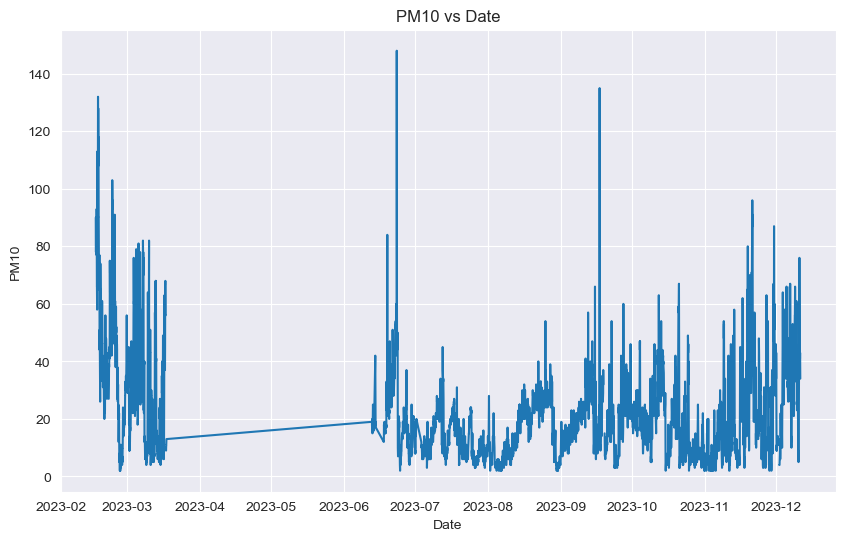

In [50]:
plot_values('Date', 'PM10')

In [51]:
df.head()

,Date,Latitude,Longitude,Altitude,NO2,PM2.5,O3,PM10
42,2023-02-15 19:35:00+00:00,46.234818,15.267305,240.0,70.0,71.0,NaN,90.0
57,2023-02-15 20:15:00+00:00,46.234818,15.267305,240.0,56.0,76.0,2.0,86.0
55,2023-02-15 20:35:00+00:00,46.234818,15.267305,240.0,56.0,76.0,2.0,86.0
95,2023-02-15 21:15:00+00:00,46.234818,15.267305,240.0,48.0,73.0,2.0,78.0
88,2023-02-15 21:35:00+00:00,46.234818,15.267305,240.0,48.0,73.0,2.0,78.0


In [52]:
df.tail()

,Date,Latitude,Longitude,Altitude,NO2,PM2.5,O3,PM10
763,2023-12-11 04:35:00+00:00,46.234818,15.267305,240.0,23.0,40.0,1.0,42.0
786,2023-12-11 05:35:00+00:00,46.234818,15.267305,240.0,24.0,38.0,1.0,41.0
713,2023-12-11 06:35:00+00:00,46.234818,15.267305,240.0,26.0,40.0,1.0,43.0
969,2023-12-11 07:35:00+00:00,46.234818,15.267305,240.0,33.0,35.0,1.0,37.0
1094,2023-12-11 08:35:00+00:00,46.234818,15.267305,240.0,46.0,28.0,1.0,34.0


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5625 entries, 42 to 1094
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   Date       5625 non-null   datetime64[ns, UTC]
 1   Latitude   5625 non-null   float64            
 2   Longitude  5625 non-null   float64            
 3   Altitude   5625 non-null   float64            
 4   NO2        5223 non-null   float64            
 5   PM2.5      5558 non-null   float64            
 6   O3         5328 non-null   float64            
 7   PM10       5558 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(7)
memory usage: 395.5 KB


In [54]:
df_weather = pd.read_csv('data/weather.csv')
df_weather.head()

,Date,temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),apparent_temperature (°C),precipitation (mm),rain (mm),snowfall (cm),surface_pressure (hPa),cloud_cover (%),wind_speed_10m (km/h),wind_direction_10m (°),soil_temperature_0_to_7cm (°C),soil_moisture_0_to_7cm (m³/m³),is_day ()
0,2023-01-01 00:15:00+00:00,7.7,85.0,5.3,5.5,0.0,0.0,0.0,992.7,7.0,6.7,144.0,2.6,0.357,0.0
1,2023-01-01 00:35:00+00:00,7.7,85.0,5.3,5.5,0.0,0.0,0.0,992.7,7.0,6.7,144.0,2.6,0.357,0.0
2,2023-01-01 01:15:00+00:00,7.8,84.0,5.2,5.7,0.0,0.0,0.0,992.8,4.0,6.4,133.0,2.1,0.356,0.0
3,2023-01-01 01:35:00+00:00,7.8,84.0,5.2,5.7,0.0,0.0,0.0,992.8,4.0,6.4,133.0,2.1,0.356,0.0
4,2023-01-01 02:15:00+00:00,4.8,92.0,3.6,1.9,0.0,0.0,0.0,992.5,10.0,9.2,141.0,1.8,0.356,0.0


In [55]:
df_weather['Date'] = pd.to_datetime(df_weather['Date'], utc=True)

In [56]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17518 entries, 0 to 17517
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype              
---  ------                          --------------  -----              
 0   Date                            17518 non-null  datetime64[ns, UTC]
 1   temperature_2m (°C)             17518 non-null  float64            
 2   relative_humidity_2m (%)        17518 non-null  float64            
 3   dew_point_2m (°C)               17518 non-null  float64            
 4   apparent_temperature (°C)       17518 non-null  float64            
 5   precipitation (mm)              17518 non-null  float64            
 6   rain (mm)                       17518 non-null  float64            
 7   snowfall (cm)                   17518 non-null  float64            
 8   surface_pressure (hPa)          17518 non-null  float64            
 9   cloud_cover (%)                 17518 non-null  float64            
 10  wind_speed

In [57]:
df = pd.merge(df, df_weather, on='Date', how='left')
df.head()

,Date,Latitude,Longitude,Altitude,NO2,PM2.5,O3,PM10,temperature_2m (°C),relative_humidity_2m (%),...,precipitation (mm),rain (mm),snowfall (cm),surface_pressure (hPa),cloud_cover (%),wind_speed_10m (km/h),wind_direction_10m (°),soil_temperature_0_to_7cm (°C),soil_moisture_0_to_7cm (m³/m³),is_day ()
0,2023-02-15 19:35:00+00:00,46.234818,15.267305,240.0,70.0,71.0,NaN,90.0,0.5,91.0,...,0.0,0.0,0.0,996.8,0.0,8.0,190.0,0.4,0.348,0.0
1,2023-02-15 20:15:00+00:00,46.234818,15.267305,240.0,56.0,76.0,2.0,86.0,0.1,92.0,...,0.0,0.0,0.0,996.8,0.0,5.9,227.0,0.2,0.348,0.0
2,2023-02-15 20:35:00+00:00,46.234818,15.267305,240.0,56.0,76.0,2.0,86.0,0.1,92.0,...,0.0,0.0,0.0,996.8,0.0,5.9,227.0,0.2,0.348,0.0
3,2023-02-15 21:15:00+00:00,46.234818,15.267305,240.0,48.0,73.0,2.0,78.0,-1.1,93.0,...,0.0,0.0,0.0,996.6,0.0,4.6,252.0,0.1,0.348,0.0
4,2023-02-15 21:35:00+00:00,46.234818,15.267305,240.0,48.0,73.0,2.0,78.0,-1.1,93.0,...,0.0,0.0,0.0,996.6,0.0,4.6,252.0,0.1,0.348,0.0


# Predprocesiranje podatkov

Zapolnjevanje manjkajočih vrednosti 

In [58]:
df.isnull().sum()

Date                                0
Latitude                            0
Longitude                           0
Altitude                            0
NO2                               402
PM2.5                              67
O3                                297
PM10                               67
temperature_2m (°C)                 1
relative_humidity_2m (%)            1
dew_point_2m (°C)                   1
apparent_temperature (°C)           1
precipitation (mm)                  1
rain (mm)                           1
snowfall (cm)                       1
surface_pressure (hPa)              1
cloud_cover (%)                     1
wind_speed_10m (km/h)               1
wind_direction_10m (°)              1
soil_temperature_0_to_7cm (°C)      1
soil_moisture_0_to_7cm (m³/m³)      1
is_day ()                           1
dtype: int64

In [59]:
cols_to_fill = df.columns[df.isnull().any()].tolist()
print(cols_to_fill)

['NO2', 'PM2.5', 'O3', 'PM10', 'temperature_2m (°C)', 'relative_humidity_2m (%)', 'dew_point_2m (°C)', 'apparent_temperature (°C)', 'precipitation (mm)', 'rain (mm)', 'snowfall (cm)', 'surface_pressure (hPa)', 'cloud_cover (%)', 'wind_speed_10m (km/h)', 'wind_direction_10m (°)', 'soil_temperature_0_to_7cm (°C)', 'soil_moisture_0_to_7cm (m³/m³)', 'is_day ()']


In [60]:
for col in cols_to_fill:
    incomplete_rows = df[df[col].isnull()]
    complete_rows = df[~df[col].isnull()]

    # Features and target columns excluding 'Date'
    features = [c for c in df.columns if c != col and c != 'Date']
    target = col

    X_train = complete_rows[features]
    y_train = complete_rows[target]

    model = HistGradientBoostingRegressor()

    model.fit(X_train, y_train)

    predicted_values = model.predict(incomplete_rows[features])

    df.loc[df[col].isnull(), col] = predicted_values

In [61]:
df.isnull().sum()

Date                              0
Latitude                          0
Longitude                         0
Altitude                          0
NO2                               0
PM2.5                             0
O3                                0
PM10                              0
temperature_2m (°C)               0
relative_humidity_2m (%)          0
dew_point_2m (°C)                 0
apparent_temperature (°C)         0
precipitation (mm)                0
rain (mm)                         0
snowfall (cm)                     0
surface_pressure (hPa)            0
cloud_cover (%)                   0
wind_speed_10m (km/h)             0
wind_direction_10m (°)            0
soil_temperature_0_to_7cm (°C)    0
soil_moisture_0_to_7cm (m³/m³)    0
is_day ()                         0
dtype: int64

# Dodajanje novih atributov

In [62]:
df["PM2.5/N02"] = df["PM2.5"] / df["NO2"]

df["PM2.5/03"] = df["PM2.5"] / df["O3"]

df['Season'] = df['Date'].dt.month.apply(lambda x: 'Winter' if (x == 12 or x <= 2) else
('Spring' if (3 <= x <= 5) else
 ('Summer' if (6 <= x <= 8) else
  ('Autumn' if (9 <= x <= 11) else None))))

df["Season"].astype('category')

df["Weekend"] = df["Date"].dt.dayofweek.apply(lambda x: 1 if (x == 5 or x == 6) else 0)

In [63]:
df.head()

,Date,Latitude,Longitude,Altitude,NO2,PM2.5,O3,PM10,temperature_2m (°C),relative_humidity_2m (%),...,cloud_cover (%),wind_speed_10m (km/h),wind_direction_10m (°),soil_temperature_0_to_7cm (°C),soil_moisture_0_to_7cm (m³/m³),is_day (),PM2.5/N02,PM2.5/03,Season,Weekend
0,2023-02-15 19:35:00+00:00,46.234818,15.267305,240.0,70.0,71.0,0.857538,90.0,0.5,91.0,...,0.0,8.0,190.0,0.4,0.348,0.0,1.014286,82.795117,Winter,0
1,2023-02-15 20:15:00+00:00,46.234818,15.267305,240.0,56.0,76.0,2.000000,86.0,0.1,92.0,...,0.0,5.9,227.0,0.2,0.348,0.0,1.357143,38.000000,Winter,0
2,2023-02-15 20:35:00+00:00,46.234818,15.267305,240.0,56.0,76.0,2.000000,86.0,0.1,92.0,...,0.0,5.9,227.0,0.2,0.348,0.0,1.357143,38.000000,Winter,0
3,2023-02-15 21:15:00+00:00,46.234818,15.267305,240.0,48.0,73.0,2.000000,78.0,-1.1,93.0,...,0.0,4.6,252.0,0.1,0.348,0.0,1.520833,36.500000,Winter,0
4,2023-02-15 21:35:00+00:00,46.234818,15.267305,240.0,48.0,73.0,2.000000,78.0,-1.1,93.0,...,0.0,4.6,252.0,0.1,0.348,0.0,1.520833,36.500000,Winter,0


In [64]:
df = pd.get_dummies(df, columns=['Season'])

In [65]:
df.head()

,Date,Latitude,Longitude,Altitude,NO2,PM2.5,O3,PM10,temperature_2m (°C),relative_humidity_2m (%),...,soil_temperature_0_to_7cm (°C),soil_moisture_0_to_7cm (m³/m³),is_day (),PM2.5/N02,PM2.5/03,Weekend,Season_Autumn,Season_Spring,Season_Summer,Season_Winter
0,2023-02-15 19:35:00+00:00,46.234818,15.267305,240.0,70.0,71.0,0.857538,90.0,0.5,91.0,...,0.4,0.348,0.0,1.014286,82.795117,0,False,False,False,True
1,2023-02-15 20:15:00+00:00,46.234818,15.267305,240.0,56.0,76.0,2.000000,86.0,0.1,92.0,...,0.2,0.348,0.0,1.357143,38.000000,0,False,False,False,True
2,2023-02-15 20:35:00+00:00,46.234818,15.267305,240.0,56.0,76.0,2.000000,86.0,0.1,92.0,...,0.2,0.348,0.0,1.357143,38.000000,0,False,False,False,True
3,2023-02-15 21:15:00+00:00,46.234818,15.267305,240.0,48.0,73.0,2.000000,78.0,-1.1,93.0,...,0.1,0.348,0.0,1.520833,36.500000,0,False,False,False,True
4,2023-02-15 21:35:00+00:00,46.234818,15.267305,240.0,48.0,73.0,2.000000,78.0,-1.1,93.0,...,0.1,0.348,0.0,1.520833,36.500000,0,False,False,False,True


# Informations gain

In [66]:
output_col = 'PM10'

input_cols = df.columns.tolist()
input_cols.remove(output_col)
input_cols.remove('Date')

information_gain_scores = mutual_info_regression(df[input_cols], df[output_col])

feature_importances = pd.Series(information_gain_scores, index=input_cols)
feature_importances.name = 'Information Gain Scores'
feature_importances.sort_values(ascending=False, inplace=True)

feature_importances.head(10)

PM2.5                             1.520793
PM2.5/03                          0.808552
PM2.5/N02                         0.560193
soil_moisture_0_to_7cm (m³/m³)    0.485285
dew_point_2m (°C)                 0.394584
soil_temperature_0_to_7cm (°C)    0.371664
apparent_temperature (°C)         0.319809
temperature_2m (°C)               0.315269
NO2                               0.312410
O3                                0.305905
Name: Information Gain Scores, dtype: float64

<Axes: >

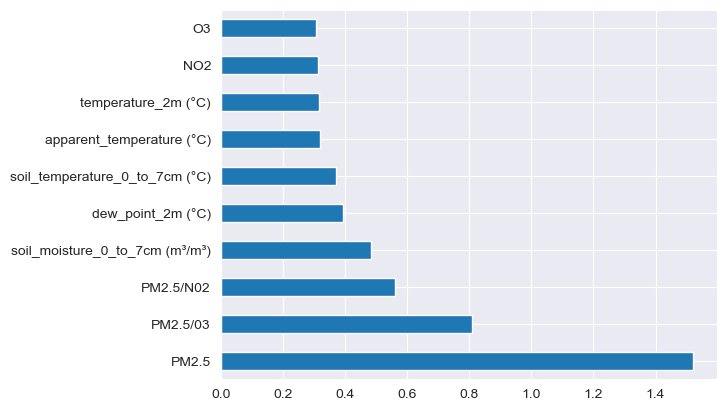

In [67]:
feature_importances.head(10).plot.barh()

Transformacija podatkov

In [68]:
def boxcox_transform(column):
    # create before and after plots for comparison
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.distplot(df[column], ax=ax[0])
    ax[0].set_title("Before Box-Cox")

    # transform data
    data = boxcox(df[column], lmbda=0.0)

    # create after plots
    sns.distplot(data, ax=ax[1])
    ax[1].set_title("After Box-Cox")

    # update dataframe
    df[column] = data

    plt.show()


In [69]:
def yeojohnson_transform(column):
    # create before and after plots for comparison
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.distplot(df[column], ax=ax[0])
    ax[0].set_title("Before Yeo-Johnson")

    # transform data
    data = yeojohnson(df[column])

    # create after plots
    sns.distplot(data[0], ax=ax[1])
    ax[1].set_title("After Yeo-Johnson")

    # update dataframe
    df[column] = data[0]

    plt.show()

In [70]:
#boxcox_transform('PM2.5')

In [71]:
#boxcox_transform('NO2')

In [72]:
#boxcox_transform("soil_moisture_0_to_7cm (m³/m³)")

In [73]:
#yeojohnson_transform("soil_temperature_0_to_7cm (°C)")

In [74]:
#yeojohnson_transform("apparent_temperature (°C)")

In [75]:
#yeojohnson_transform("dew_point_2m (°C)")

In [76]:
#boxcox_transform("surface_pressure (hPa)")

In [77]:
#boxcox_transform("PM2.5/N02")

In [78]:
#boxcox_transform("PM2.5/03")

# Izdelava modela

In [79]:
#selected_features = columns_to_normalize + columns_to_standardize
data = df["PM10"]
time_series = data.values.reshape(-1, 1)

In [80]:
test_data_size = int(df.shape[0] * 0.2)
print(f"Test data size: {test_data_size}")

Test data size: 1125


In [81]:
train_data = time_series[:-test_data_size]
test_data = time_series[-test_data_size:]

In [82]:
scaler = MinMaxScaler()

train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

In [83]:
def create_time_series(data, window_size=48):
    X, y = [], []
    for i in range(len(data) - window_size):
        window = data[i:(i + window_size)]
        target = data[i + window_size]
        X.append(window)
        y.append(target)
    return np.array(X), np.array(y)


In [84]:
days = 7
window_size = 48 * days  # od 0:15 do 0:15 naslednjega dne je 48 meritev

In [85]:
X_train, y_train = create_time_series(train_data, window_size)
X_test, y_test = create_time_series(test_data, window_size)

In [86]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Verifying shapes
print(f"Shape of training data: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Shape of testing data: X_test: {X_test.shape}, y_test: {y_test.shape}")

Shape of training data: X_train: (4164, 1, 336), y_train: (4164, 1)
Shape of testing data: X_test: (789, 1, 336), y_test: (789, 1)


In [87]:
def create_lstm_model(units=32, optimizer='adam', activation='relu', batch_size=32, epochs=10, dropout_rate=0.2):
    model = Sequential(name="LSTM")
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units))
    model.add(Dense(units=32, activation=activation))
    model.add(Dense(units=1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model


def create_simple_rnn_model(units=32, optimizer='adam', activation='relu', batch_size=32, epochs=10, dropout_rate=0.2):
    model = Sequential(name="RNN")
    model.add(SimpleRNN(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(SimpleRNN(units=units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(SimpleRNN(units=units))
    model.add(Dense(units=32, activation=activation))
    model.add(Dense(units=1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model


def create_gru_model(units=32, optimizer='adam', activation='relu', batch_size=32, epochs=10, dropout_rate=0.2):
    model = Sequential(name="GRU")
    model.add(GRU(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(GRU(units=units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(GRU(units=units))
    model.add(Dense(units=32, activation=activation))
    model.add(Dense(units=1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [88]:
model_fns = [create_lstm_model, create_simple_rnn_model, create_gru_model]

In [89]:
param_grid = {
    'units': [32, 64, 128],
    'optimizer': ['adam', 'rmsprop', 'SGD'],
    'activation': ['relu', 'sigmoid', 'tanh'],
    'batch_size': [32, 64, 128],
    'epochs': [10, 25, 50],
    'dropout_rate': [0.2, 0.3, 0.4]
}

In [90]:
best_score = float('-inf')
best_model = None
best_grid_result = None
history = {}
best_models = {}

model_names = ['LSTM', 'RNN', 'GRU']

for idx, create_model_fn in enumerate(model_fns):

    model = KerasRegressor(build_fn=create_model_fn, verbose=0)

    grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              scoring='neg_mean_squared_error', cv=3, n_iter=1,
                              random_state=1234)
    grid_result = grid.fit(X_train, y_train, verbose=1, validation_data=(X_test, y_test))
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    history[model_names[idx]] = grid_result.best_estimator_.model.history.history
    best_models[model_names[idx]] = grid_result.best_estimator_.model

    if grid_result.best_score_ > best_score:
        best_score = grid_result.best_score_
        best_model = grid_result.best_estimator_.model
        best_grid_result = grid_result

print("Best model found:", best_model.name)
print("Best score:", best_score)

/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_66759/2860036950.py:11: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model_fn, verbose=0)


Epoch 1/50
22/22 [==============================] - 2s 21ms/step - loss: 0.0055 - val_loss: 0.0202
Epoch 2/50
22/22 [==============================] - 0s 4ms/step - loss: 0.0046 - val_loss: 0.0203
Epoch 3/50
22/22 [==============================] - 0s 4ms/step - loss: 0.0046 - val_loss: 0.0214
Epoch 4/50
22/22 [==============================] - 0s 4ms/step - loss: 0.0045 - val_loss: 0.0189
Epoch 5/50
22/22 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0206
Epoch 6/50
22/22 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0185
Epoch 7/50
22/22 [==============================] - 0s 3ms/step - loss: 0.0046 - val_loss: 0.0191
Epoch 8/50
22/22 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0199
Epoch 9/50
22/22 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0207
Epoch 10/50
22/22 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0203
Epoch 11/50
22/22 

/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_66759/2860036950.py:11: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model_fn, verbose=0)


22/22 [==============================] - 1s 8ms/step - loss: 0.0219 - val_loss: 0.0139
Epoch 2/50
22/22 [==============================] - 0s 2ms/step - loss: 0.0060 - val_loss: 0.0164
Epoch 3/50
22/22 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0127
Epoch 4/50
22/22 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0133
Epoch 5/50
22/22 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0148
Epoch 6/50
22/22 [==============================] - 0s 2ms/step - loss: 0.0031 - val_loss: 0.0103
Epoch 7/50
22/22 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0113
Epoch 8/50
22/22 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0135
Epoch 9/50
22/22 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0125
Epoch 10/50
22/22 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0084
Epoch 11/50
22/22 [===========

/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_66759/2860036950.py:11: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model_fn, verbose=0)


Epoch 1/50
22/22 [==============================] - 2s 18ms/step - loss: 0.0051 - val_loss: 0.0170
Epoch 2/50
22/22 [==============================] - 0s 3ms/step - loss: 0.0040 - val_loss: 0.0156
Epoch 3/50
22/22 [==============================] - 0s 4ms/step - loss: 0.0036 - val_loss: 0.0140
Epoch 4/50
22/22 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 0.0124
Epoch 5/50
22/22 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 0.0121
Epoch 6/50
22/22 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0154
Epoch 7/50
22/22 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0103
Epoch 8/50
22/22 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0136
Epoch 9/50
22/22 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0112
Epoch 10/50
22/22 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0092
Epoch 11/50
22/22 

In [91]:
def plot_history(history):
    plt.figure(figsize=(12, 8))
    for name, values in history.items():
        plt.plot(values['loss'], label=name)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs Epochs')
    plt.legend()
    plt.show()

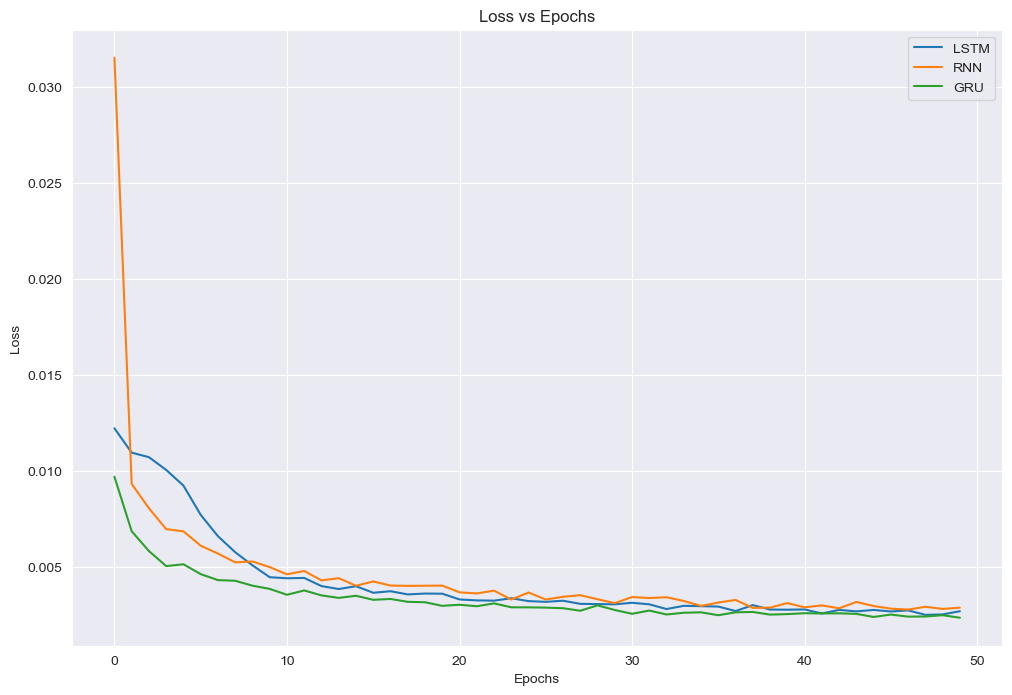

In [92]:
plot_history(history)

In [93]:
results = {
    'MAE': [],
    'MSE': [],
    'EVS': []
}

y_test = scaler.inverse_transform(y_test)

for model in best_models.values():
    predicted = model.predict(X_test)
    predicted = scaler.inverse_transform(predicted)

    mse = mean_squared_error(y_test, predicted)
    mae = mean_absolute_error(y_test, predicted)
    evs = explained_variance_score(y_test, predicted)

    results['MSE'].append((model.name, mse))
    results['MAE'].append((model.name, mae))
    results['EVS'].append((model.name, evs))

    print(f'{model.name} - MSE: {mse:.2f}')
    print(f'{model.name} - MAE: {mae:.2f}')
    print(f'{model.name} - EVS: {evs:.2f}')
    print("-" * 20)


25/25 [==============================] - 0s 732us/step
LSTM - MSE: 98.00
LSTM - MAE: 7.39
LSTM - EVS: 0.72
--------------------
25/25 [==============================] - 0s 792us/step
RNN - MSE: 84.05
RNN - MAE: 6.88
RNN - EVS: 0.76
--------------------
25/25 [==============================] - 0s 685us/step
GRU - MSE: 111.60
GRU - MAE: 8.54
GRU - EVS: 0.74
--------------------


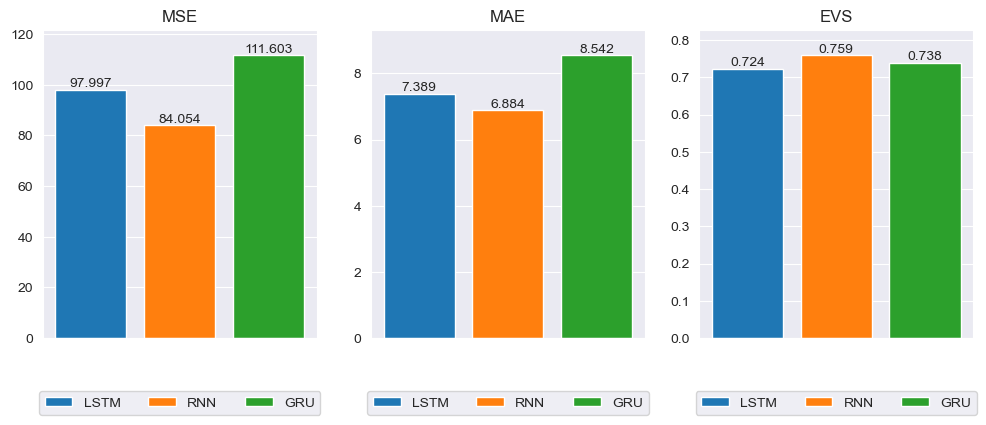

In [94]:
metrics = ['MSE', 'MAE', 'EVS']

width = 0.8
cols = len(metrics)

fig, axs = plt.subplots(1, cols, figsize=(12, 4))

for i, metric in enumerate(metrics):
    ax = axs[i]
    max = -float('inf')

    for j, model in enumerate(model_names):
        value = results[metric][j][1]
        if value > max:
            max = value
        ax.bar(j, value, width, label=model)
        ax.text(j, value, str(round(value, 3)), ha='center', va='bottom')

    ax.set_ylim([0, max * 1.09])
    ax.set_title(f'{metric}')
    ax.set_xticks([], [])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

plt.show()

In [95]:
dates = df['Date'].values

In [96]:
y_pred = best_model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)


25/25 [==============================] - 0s 1ms/step


In [97]:
df_output = pd.DataFrame(
    {'Date': dates[-test_data_size + window_size:], 'Actual': y_test.reshape(-1), 'Predicted': y_pred.reshape(-1)})
df_output.head(20)

,Date,Actual,Predicted
0,2023-11-08 12:35:00,5.0,9.445443
1,2023-11-08 13:35:00,5.0,9.162111
2,2023-11-08 14:35:00,6.0,10.229771
3,2023-11-08 15:35:00,7.0,11.181838
4,2023-11-08 16:35:00,8.0,11.251383
5,2023-11-08 17:35:00,23.0,11.618415
6,2023-11-08 18:35:00,29.0,18.261871
7,2023-11-08 19:35:00,30.0,24.637085
8,2023-11-08 20:35:00,44.0,28.592344
9,2023-11-08 21:35:00,52.0,35.429119


In [98]:
def plot_results():
    plt.figure(figsize=(12, 8))
    plt.plot(df_output['Date'], df_output["Actual"], label='Actual')
    plt.plot(df_output['Date'], df_output['Predicted'], label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('PM10')
    plt.title('PM10 vs Time')
    plt.legend()
    plt.show()

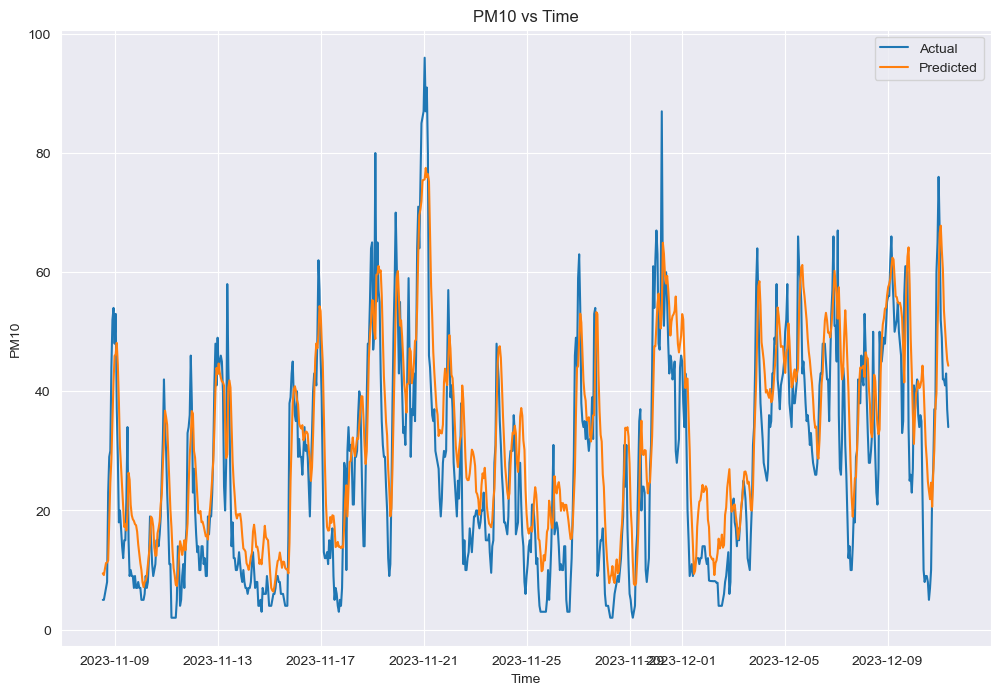

In [99]:
plot_results()

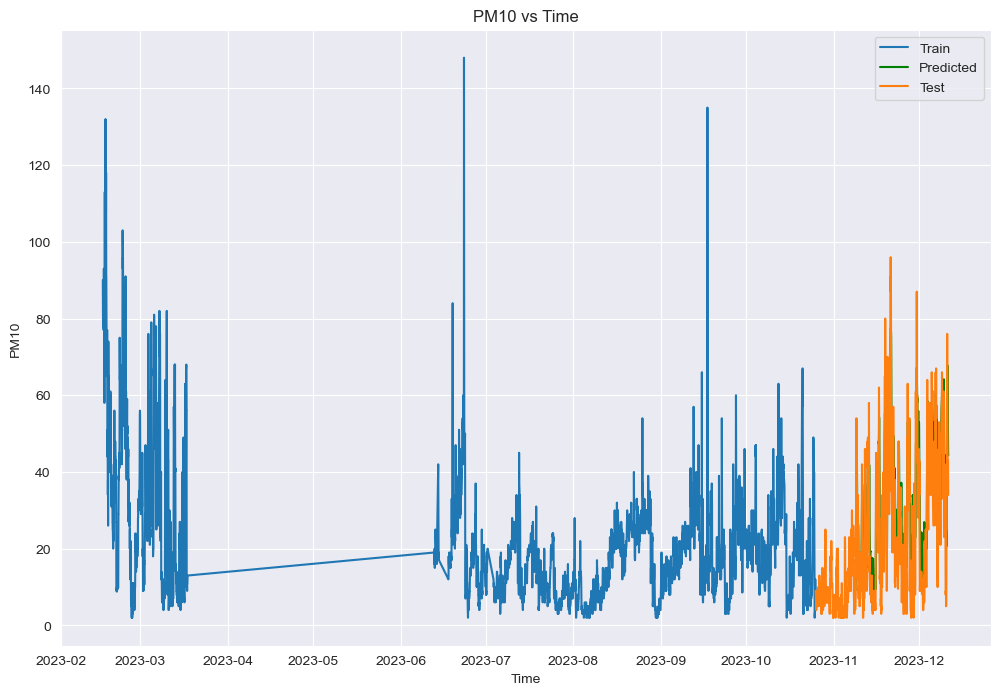

In [100]:
plt.figure(figsize=(12, 8))
plt.plot(df["Date"].iloc[:-test_data_size], df["PM10"].iloc[:-test_data_size], label='Train')
plt.plot(df_output['Date'], df_output['Predicted'], label='Predicted', color='green')
plt.plot(df["Date"].iloc[-test_data_size:], df["PM10"].iloc[-test_data_size:], label='Test')
plt.xlabel('Time')
plt.ylabel('PM10')
plt.title('PM10 vs Time')
plt.legend()
plt.show()